# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
x = datasets.MNIST('data', download = True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [4]:
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [7]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

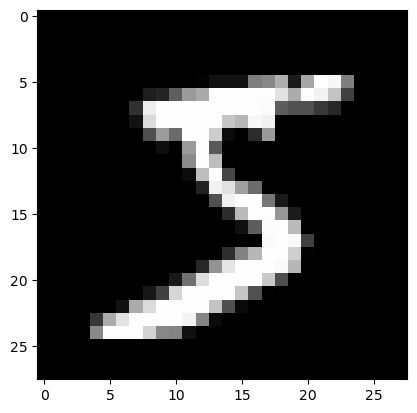

In [9]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

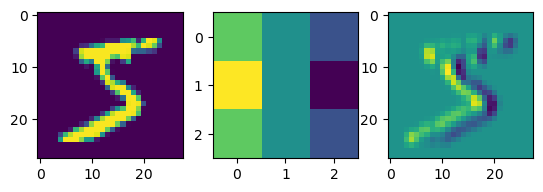

In [10]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [14]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

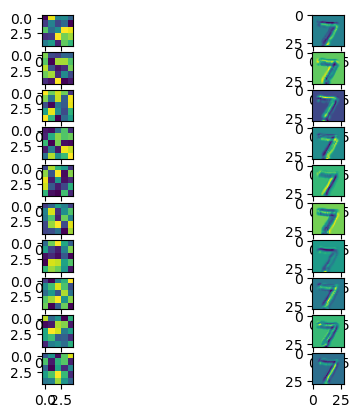

In [15]:
visualize()

# Predict Using Network

In [16]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [17]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5] 

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([1, 6, 6, 7, 1])

# First Test and Train

In [18]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [19]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 7%



In [20]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [21]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.343359
Train loss: 2.005180
Train loss: 1.082788
Train loss: 0.826778
Train loss: 0.711702
Train loss: 0.652482
Train loss: 0.399386
Train loss: 0.556867
Train loss: 0.551220
Train loss: 0.573595


# Train Network

In [22]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.356878
Train loss: 1.968206
Train loss: 0.877850
Train loss: 0.911721
Train loss: 0.607741
Train loss: 0.547399
Train loss: 0.617802
Train loss: 0.520681
Train loss: 0.607125
Train loss: 0.361453
Test accuracy: 94%

Train loss: 0.319009
Train loss: 0.354175
Train loss: 0.345014
Train loss: 0.491386
Train loss: 0.345394
Train loss: 0.356788
Train loss: 0.387106
Train loss: 0.511042
Train loss: 0.654627
Train loss: 0.380121
Test accuracy: 96%

Train loss: 0.264236
Train loss: 0.236490
Train loss: 0.184898
Train loss: 0.417731
Train loss: 0.368375
Train loss: 0.248946
Train loss: 0.346408
Train loss: 0.381406
Train loss: 0.756577
Train loss: 0.444556
Test accuracy: 97%

Train loss: 0.366049
Train loss: 0.162583
Train loss: 0.215228
Train loss: 0.355084
Train loss: 0.177053
Train loss: 0.224563
Train loss: 0.288186
Train loss: 0.344814
Train loss: 0.489425
Train loss: 0.208329
Test accuracy: 97%

Train loss: 0.156961
Train loss: 0.214645
Train loss: 0.165658
Train loss: 0.419

# Inspect Network

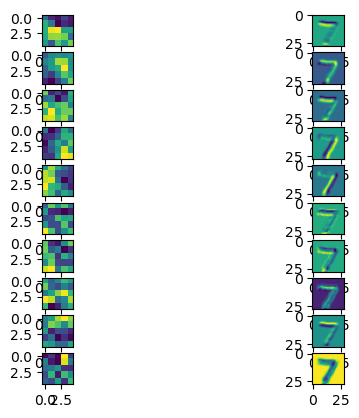

In [23]:
visualize()

In [24]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [25]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [61]:
# set seed for reproducability
torch.manual_seed(79)

In [62]:
# testing accuracy with 60,000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [63]:
# Create a new network and optimizer each time you try a new training set, for 60,000 images
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.346865
Train loss: 1.930648
Train loss: 1.088642
Train loss: 0.820391
Train loss: 0.682624
Train loss: 0.730457
Train loss: 0.481239
Train loss: 0.557512
Train loss: 0.625634
Train loss: 0.660586
Test accuracy: 94%

Train loss: 0.499390
Train loss: 0.419007
Train loss: 0.522255
Train loss: 0.438031
Train loss: 0.347832
Train loss: 0.308538
Train loss: 0.340453
Train loss: 0.367087
Train loss: 0.469510
Train loss: 0.387389
Test accuracy: 96%

Train loss: 0.313975
Train loss: 0.300178
Train loss: 0.241246
Train loss: 0.350251
Train loss: 0.199448
Train loss: 0.223602
Train loss: 0.196808
Train loss: 0.378105
Train loss: 0.296444
Train loss: 0.311879
Test accuracy: 97%

Train loss: 0.117884
Train loss: 0.414321
Train loss: 0.163604
Train loss: 0.369000
Train loss: 0.156494
Train loss: 0.224554
Train loss: 0.131930
Train loss: 0.418218
Train loss: 0.254769
Train loss: 0.262813
Test accuracy: 98%

Train loss: 0.256533
Train loss: 0.178143
Train loss: 0.194282
Train loss: 0.146

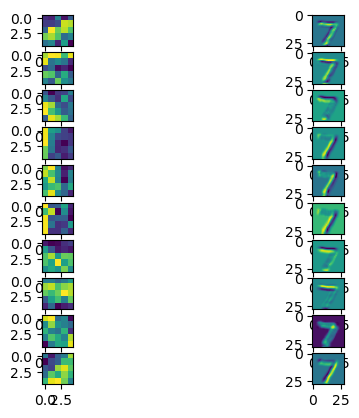

In [65]:
visualize()

In [66]:
# testing accuracy with 30,000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [67]:
# Create a new network and optimizer each time you try a new training set, for 30,000 images
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.328027
Train loss: 1.869693
Train loss: 1.057850
Train loss: 0.876915
Train loss: 0.619651
Test accuracy: 90%

Train loss: 0.723219
Train loss: 0.567526
Train loss: 0.472479
Train loss: 0.593958
Train loss: 0.304889
Test accuracy: 94%

Train loss: 0.453531
Train loss: 0.322705
Train loss: 0.295430
Train loss: 0.364974
Train loss: 0.399228
Test accuracy: 95%

Train loss: 0.415296
Train loss: 0.260455
Train loss: 0.266494
Train loss: 0.643962
Train loss: 0.337144
Test accuracy: 96%

Train loss: 0.382646
Train loss: 0.345260
Train loss: 0.205752
Train loss: 0.280177
Train loss: 0.281921
Test accuracy: 97%



In [68]:
# testing accuracy with 6,000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [69]:
# Create a new network and optimizer each time you try a new training set, for 6,000 images
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

Train loss: 2.301452


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 62%

Train loss: 1.955975
Test accuracy: 83%

Train loss: 1.115575
Test accuracy: 87%

Train loss: 0.808531
Test accuracy: 89%

Train loss: 0.641297
Test accuracy: 91%



In [70]:
# testing accuracy with 3,000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [71]:
# Create a new network and optimizer each time you try a new training set, for 3,000 images
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

Train loss: 2.327745


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 44%

Train loss: 2.207141
Test accuracy: 64%

Train loss: 1.971165
Test accuracy: 75%

Train loss: 1.583297
Test accuracy: 81%

Train loss: 1.085767
Test accuracy: 84%



In [72]:
# testing accuracy with 600 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [73]:
# Create a new network and optimizer each time you try a new training set, for 600 images
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

# print weights for training on 600 images
for name, param in network.named_parameters():
    print(f"{name}: {param.data.shape}") 

Train loss: 2.300685


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_38557/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 11%

Train loss: 2.301563
Test accuracy: 13%

Train loss: 2.263897
Test accuracy: 22%

Train loss: 2.269645
Test accuracy: 32%

Train loss: 2.264123
Test accuracy: 39%

conv1.weight: torch.Size([10, 1, 5, 5])
conv1.bias: torch.Size([10])
conv2.weight: torch.Size([20, 10, 5, 5])
conv2.bias: torch.Size([20])
fc1.weight: torch.Size([50, 320])
fc1.bias: torch.Size([50])
fc2.weight: torch.Size([10, 50])
fc2.bias: torch.Size([10])


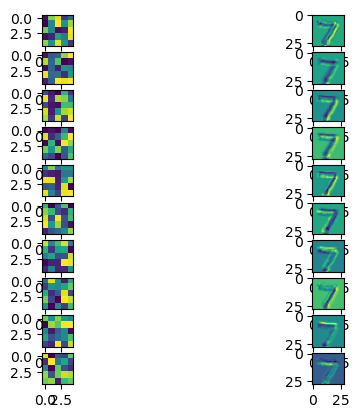

In [74]:
visualize()

In [ ]:
# 1a, accuracies for the following number of images used for training
# 60,000: 98%
# 30,000: 97%
# 6,000: 91%
# 3,000: 84%
# 600: 39%

In [ ]:
# 1b, how do weights look different for training with 60,000 vs 600?
# With 60,000 images to train on, there are clear trends in the same colors being near each other on the grid plots
# Whereas with just 600 images, there is very little distinct clustering and it is pretty random